In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
from cv.data.cifar100 import CLASSES
from cv.data.dataset import CIFAR100
import albumentations as A
from cv.utils.config import parse_config
import torch
from cv.utils.build import build_model
from cv.data.transforms import make_classification_eval_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

%config InlineBackend.figure_formats = ['retina']

In [3]:
DATA_DIR = Path("/raid4/datasets")

In [4]:
train_dataset = CIFAR100(root=DATA_DIR, train=True)

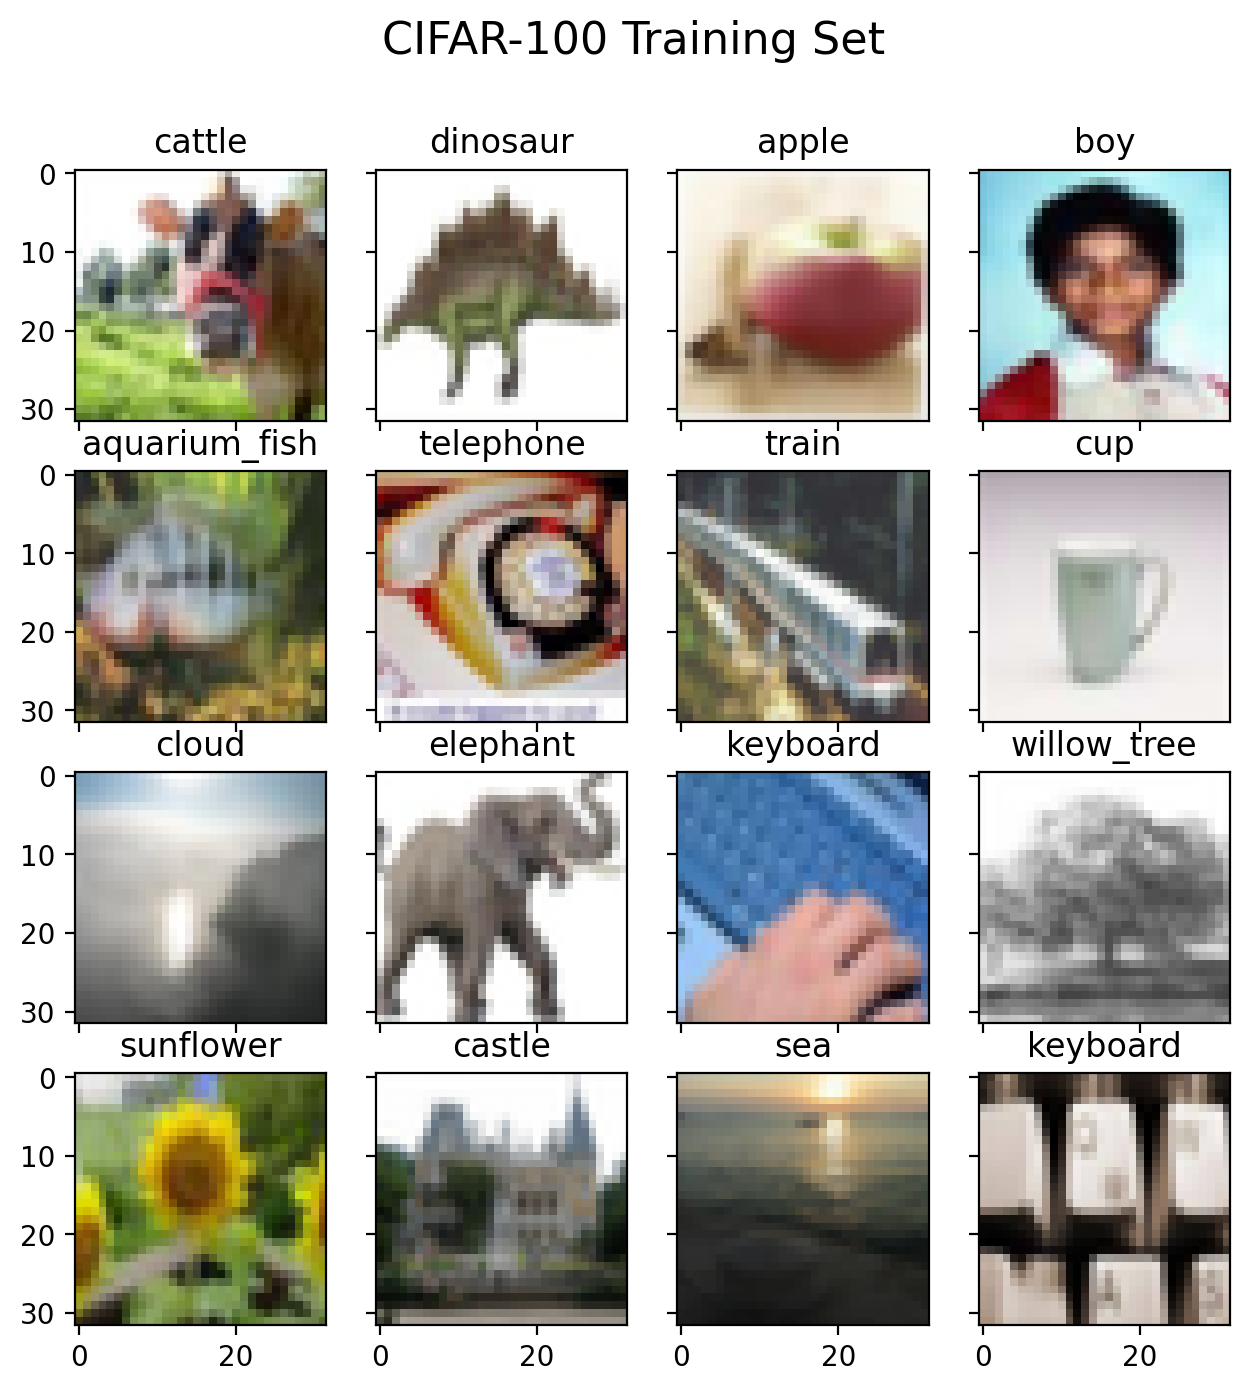

In [5]:
fig = plt.figure(figsize=(7.5, 7.5))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
    axes_pad=0.25,  # pad between Axes in inch.
)
fig.suptitle("CIFAR-100 Training Set", fontsize=16)

for i, ax in enumerate(grid):
    image, label = train_dataset[i]
    ax.imshow(image)
    ax.set_title(CLASSES[label])

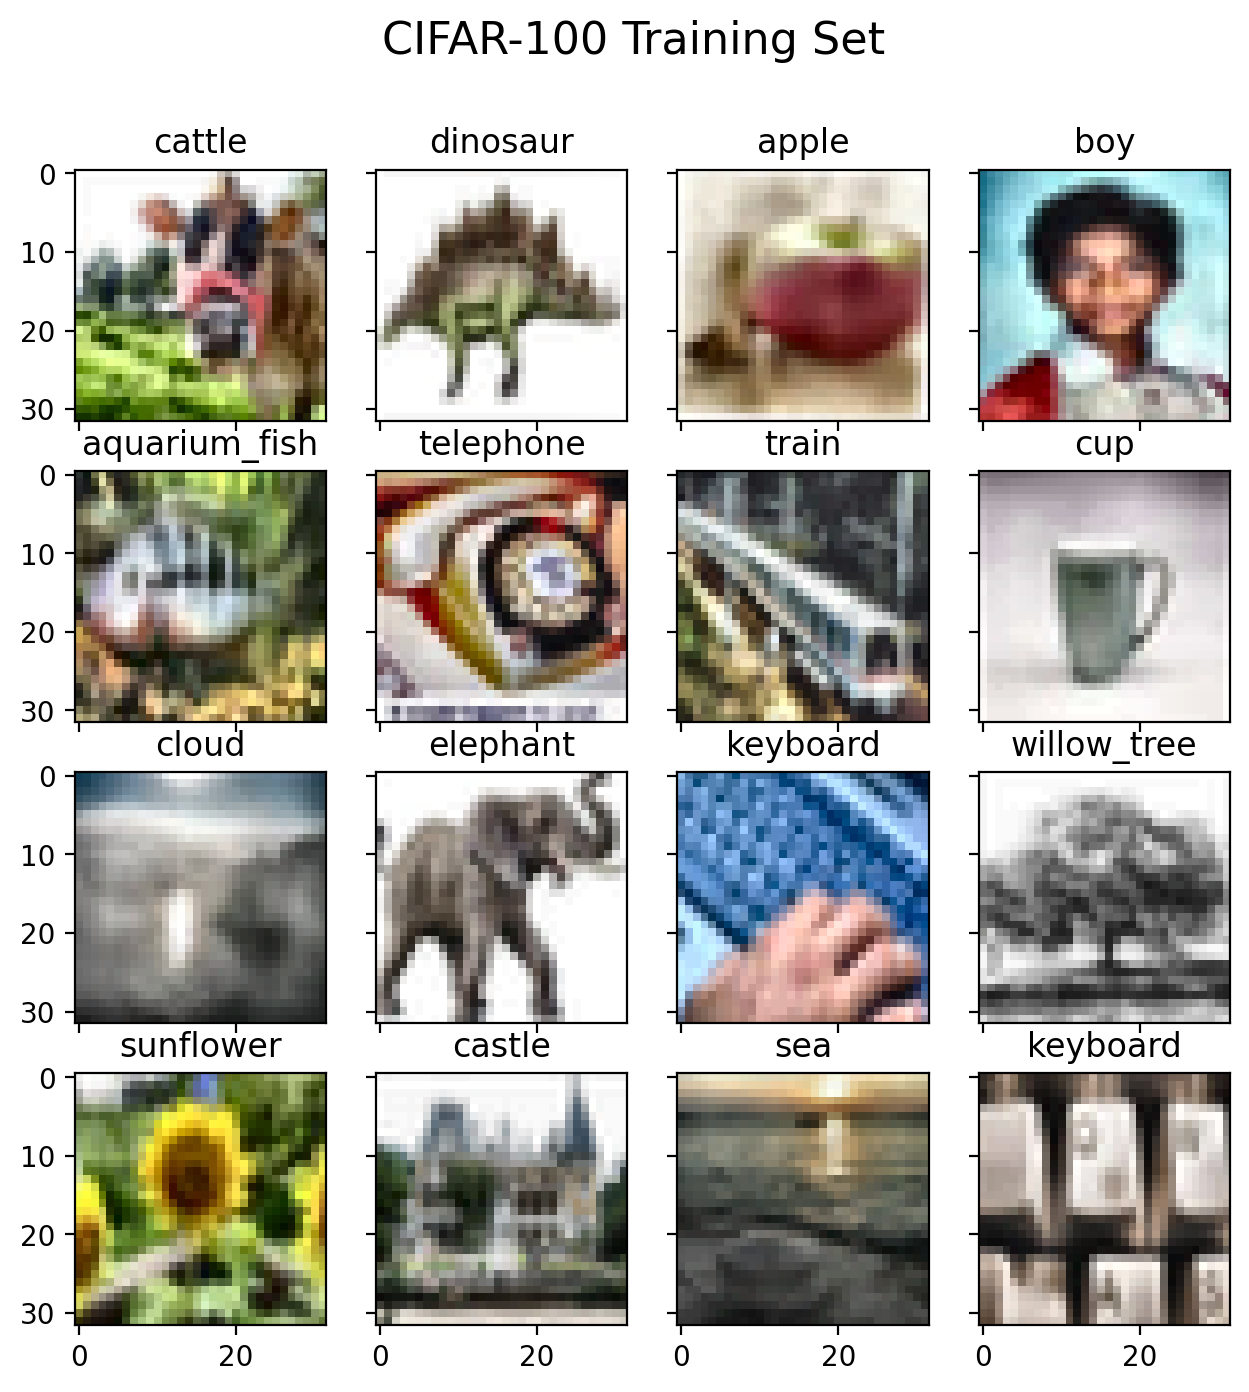

In [6]:
fig = plt.figure(figsize=(7.5, 7.5))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
    axes_pad=0.25,  # pad between Axes in inch.
)
fig.suptitle("CIFAR-100 Training Set", fontsize=16)

normalize = A.CLAHE(p=1.0, tile_grid_size=(4, 4))

for i, ax in enumerate(grid):
    image, label = train_dataset[i]
    image = normalize(image=image)["image"]
    ax.imshow(image)
    ax.set_title(CLASSES[label])

In [7]:
ood_dataset = np.load(DATA_DIR.joinpath("cifar-100-ood", "distortion00.npy"))

In [8]:
idx = [9999, 19999, 29999, 39999, 49999]

In [9]:
ood_sample_dataset = ood_dataset[idx]

In [10]:
ood_sample_dataset.shape

(5, 32, 32, 3)

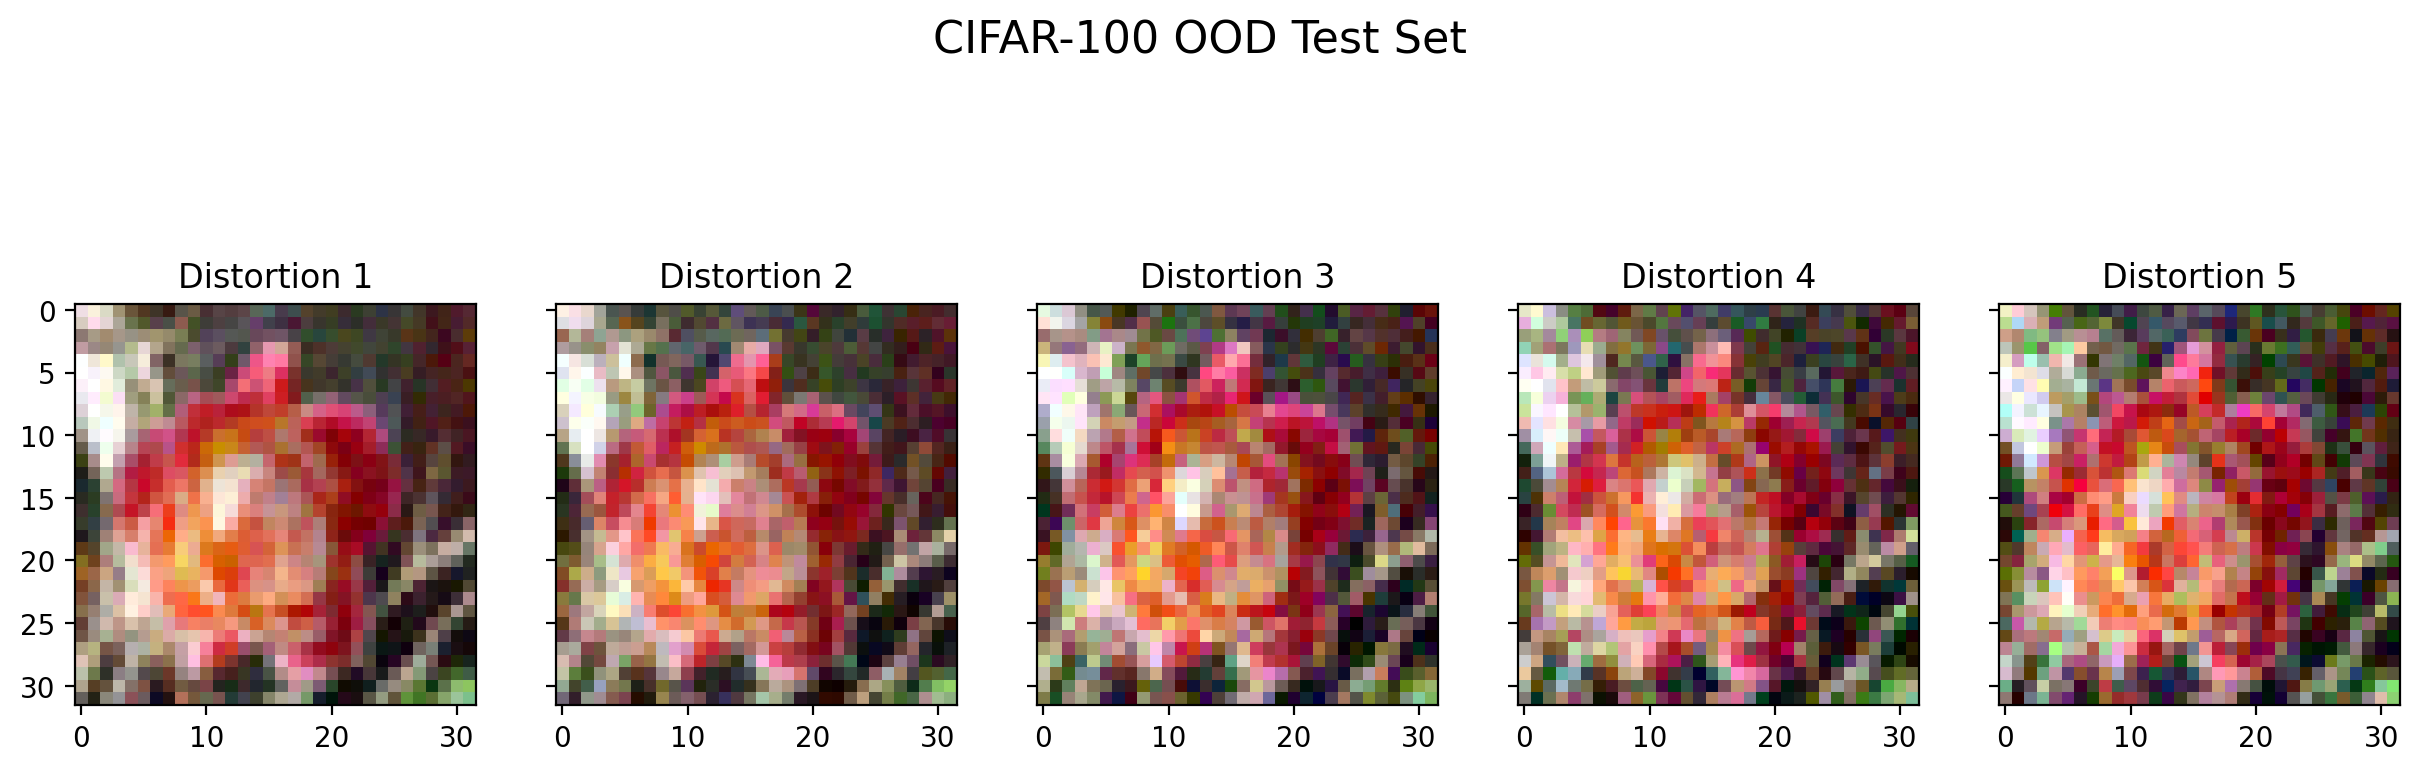

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey=True, sharex=True)

fig.suptitle("CIFAR-100 OOD Test Set", fontsize=16)

for i, ax in enumerate(axs.ravel()):
    image = ood_sample_dataset[i]
    ax.imshow(image)
    ax.set_title(f"Distortion {i + 1}")


In [12]:
base_config_path = Path("../config")

config = parse_config(
    base_config_path.joinpath("inference.yml"),
    base_config_path.joinpath("models", "convnet.yml"),
    base_config_path.joinpath("wandb.yml"),
)

In [13]:
config.ckpt_path = Path(f"../outputs/{config.experiment_name}/best_model.pth")

In [14]:
model = build_model(config).to(config.device)

state_dict = torch.load(config.ckpt_path, weights_only=False)

model.load_state_dict(state_dict["model"])

for param in model.parameters():
    param.requires_grad = False

model.eval()

ConvNet(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [15]:
transform_test = make_classification_eval_transform(
    resize_size=32, crop_size=32, mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD
)

In [17]:
with torch.inference_mode():
    for i in range(ood_sample_dataset.shape[0]):
        with torch.inference_mode():
            inp = transform_test(image=ood_sample_dataset[i])["image"]
            inp = inp.unsqueeze_(0).to(config.device)
            pred = model(inp)
        pred = pred.softmax(dim=-1)
        print(pred.topk(k=5))
        pred = pred.argmax(dim=-1)
        pred = pred.cpu().item()
        print(CLASSES[pred])

torch.return_types.topk(
values=tensor([[0.8726, 0.0529, 0.0516, 0.0098, 0.0059]], device='cuda:0'),
indices=tensor([[70, 62, 92, 54, 26]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[0.9586, 0.0120, 0.0097, 0.0082, 0.0023]], device='cuda:0'),
indices=tensor([[70, 62, 92, 26, 54]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[0.7130, 0.0861, 0.0390, 0.0293, 0.0231]], device='cuda:0'),
indices=tensor([[70, 62, 92, 51, 14]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[0.5878, 0.0901, 0.0357, 0.0335, 0.0229]], device='cuda:0'),
indices=tensor([[70, 51, 62, 92, 26]], device='cuda:0'))
rose
torch.return_types.topk(
values=tensor([[0.6605, 0.0833, 0.0558, 0.0446, 0.0248]], device='cuda:0'),
indices=tensor([[70, 62, 51, 92, 78]], device='cuda:0'))
rose
